# Voice Classification

I'll be using this notebook to make a neural network to use for voice classification between real and cloned voices. The real voices will be from the Mozilla Common Voice Dataset, which can be found here: https://commonvoice.mozilla.org/en/datasets. The cloned voices will be from fine-tuning pretrained models, from Coqui TTS, on the TIMIT dataset. The voice cloning notebook shows the steps to train a voice cloning model or there are examples on the Coqui TTS website: https://tts.readthedocs.io/en/latest/index.html.

In [1]:
## import modules

import os
import librosa
import librosa.display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import models, layers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Data Preparation

Let's take a look at extracting features from audio files so we can use them in neural networks.

In [2]:
## Load one audio file to examine

import IPython.display as ipd

filepath = "D:/data/common voice/real/common_voice_en_30670792.mp3"
ipd.Audio(filepath)

I'll use librosa to load and display the audio file. Librosa is a python library for audio manipulation and can be used to extract numerical features from audio files.

C:\Users\Chris\Anaconda3\envs\torch\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


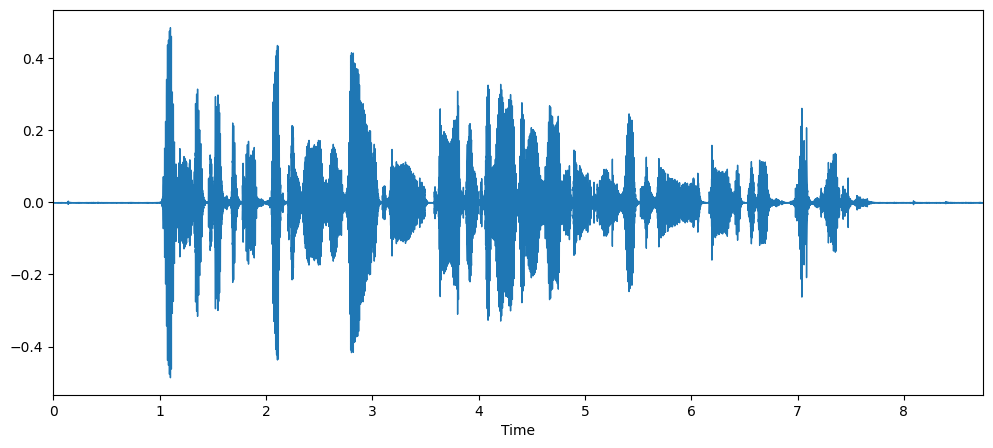

In [3]:
data, sr = librosa.load(filepath)
plt.figure(figsize=(12, 5))
librosa.display.waveplot(data, sr=sr)

In [4]:
## use librosa to get the MFCC of the audio file

test_mfcc = librosa.feature.mfcc(y=data, sr=sr, n_mfcc=40)
print(test_mfcc.shape)
print(test_mfcc)

(40, 377)
[[-6.2486414e+02 -6.2319159e+02 -6.1515594e+02 ... -6.0812030e+02
  -6.0505212e+02 -6.1035474e+02]
 [ 0.0000000e+00  2.3103614e+00  1.3238200e+01 ...  2.1722370e+01
   2.6229546e+01  1.9109188e+01]
 [ 0.0000000e+00  2.1522589e+00  1.1850716e+01 ...  1.7031681e+01
   2.1504761e+01  1.5427137e+01]
 ...
 [ 0.0000000e+00 -8.3617270e-01 -2.7511363e+00 ... -2.3154681e+00
  -4.0555463e+00 -2.7270427e+00]
 [ 0.0000000e+00 -1.0668976e+00 -2.7203770e+00 ... -1.7408888e+00
  -2.0642238e+00 -1.2987273e+00]
 [ 0.0000000e+00 -1.3126867e+00 -2.9049358e+00 ... -1.2421603e+00
  -9.4674855e-02  1.2422541e-01]]


In [5]:
## get the mean values of the MFCC so that we have numerical values we can assign to each audio file

np.mean(test_mfcc.T, axis=0)

array([-405.3368   ,   82.429245 ,    5.497143 ,   37.57439  ,
         24.420523 ,   -1.2945429,   -7.124615 ,   -8.317127 ,
        -16.579996 ,    2.0761664,   -3.9497929,   -3.829274 ,
         -6.0042624,    2.031469 ,   -6.4844146,   -1.1308863,
         -7.2476673,   -2.8352613,   -4.823599 ,    3.3387973,
         -6.990753 ,   -2.8358443,   -6.5230365,   -2.5930576,
         -7.6347876,   -0.6463431,   -4.384895 ,   -5.3633265,
         -3.3147814,   -3.626907 ,   -2.4544435,   -4.725619 ,
         -2.5984178,   -4.3909454,   -4.5811434,   -2.3500514,
         -5.8520255,   -1.9479192,   -3.3003166,   -1.5218477],
      dtype=float32)

I'll be using librosa to extract the MFCC, Chroma, and Mel numerical values from each audio file. Each MFCC is an array of length 40, Chroma has a length of 12, and Mel has a length of 128. I'll have 180 numerical features for each audio clip from the features I've chosen.

In [6]:
## This function will ouput the array of each feature from the audio file

def get_features(file_path):
    audio, sample_rate = librosa.load(file_path)
    mfcc = np.mean(librosa.feature.mfcc(y=audio, n_mfcc=40, sr=sample_rate).T, axis=0)
    stft = np.abs(librosa.stft(y=audio))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    mel = np.mean(librosa.feature.melspectrogram(y=audio, sr=sample_rate).T, axis=0)
    
    return mfcc, chroma, mel

In [7]:
## get the list of filenames for the audio files

cv = os.listdir('D:/data/common voice/cloned')
rv = os.listdir('D:/data/common voice/real')

In [8]:
## extract the features for the audio files and place them in each respective list

cloned_features = []
real_features = []

for filename in cv:
    path = 'D:/data/common voice/cloned/'
    
    cloned_features.append(get_features(path + filename))
    
for filename in rv:
    path = 'D:/data/common voice/real/'
    
    real_features.append(get_features(path + filename))

C:\Users\Chris\Anaconda3\envs\torch\lib\site-packages\librosa\core\audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


In [9]:
## concatenate the arrays for each file so we have a single array for each audio file

cloned_features = [np.concatenate((x[0], x[1], x[2]), axis=0) for x in cloned_features]
real_features = [np.concatenate((x[0], x[1], x[2]), axis=0) for x in real_features]

In [10]:
print(np.array(cloned_features).shape)
print(np.array(real_features).shape)

(400, 180)
(500, 180)


We can see that we have 400 cloned voices and 500 real voices, each with 180 features.

In [14]:
## combine the real and cloned features to make the independent and dependent variables

X = np.append(cloned_features, real_features, axis=0)
y = np.append(np.zeros(400), np.ones(500)).reshape(900, 1)

In [15]:
## make the train, test, and validation sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=10)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state= 10)

In [16]:
## check the length of each set

print(f'X_train:{len(X_train)} val:{len(X_val)} test:{len(X_test)} Y_train:{len(y_train)} val:{len(y_val)} test:{len(y_test)}')

X_train:648 val:72 test:180 Y_train:648 val:72 test:180


In [17]:
## normalize the data using StandardScaler

ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_val = ss.transform(X_val)
X_test = ss.transform(X_test)

# Modeling

I'll be making a simple dense model and a LSTM model for voice classification. Let's see which model performs best.

In [21]:
model = tf.keras.Sequential([
    layers.Dense(256, activation='relu', input_shape=(180,)),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               46336     
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 batch_normalization_1 (Batc  (None, 128)              512       
 hNormalization)                                                 
                                                                 
 dropout_1 (Dropout)         (None, 128)               0

In [22]:
model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val))

Epoch 1/100
21/21 [==============================] - 2s 16ms/step - loss: 0.5630 - accuracy: 0.7438 - val_loss: 0.2792 - val_accuracy: 0.9444
Epoch 2/100
21/21 [==============================] - 0s 4ms/step - loss: 0.2096 - accuracy: 0.9244 - val_loss: 0.1573 - val_accuracy: 0.9722
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 0.1081 - accuracy: 0.9691 - val_loss: 0.0995 - val_accuracy: 0.9861
Epoch 4/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0754 - accuracy: 0.9846 - val_loss: 0.0674 - val_accuracy: 0.9861
Epoch 5/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0512 - accuracy: 0.9877 - val_loss: 0.0506 - val_accuracy: 0.9861
Epoch 6/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0916 - accuracy: 0.9722 - val_loss: 0.0342 - val_accuracy: 0.9861
Epoch 7/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0369 - accuracy: 0.9938 - val_loss: 0.0269 - val_accuracy: 0.9861
Epoch 8/100


Epoch 59/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0044 - accuracy: 0.9985 - val_loss: 0.0707 - val_accuracy: 0.9861
Epoch 60/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0026 - accuracy: 1.0000 - val_loss: 0.0732 - val_accuracy: 0.9861
Epoch 61/100
21/21 [==============================] - 0s 4ms/step - loss: 0.0056 - accuracy: 0.9985 - val_loss: 0.0770 - val_accuracy: 0.9861
Epoch 62/100
21/21 [==============================] - 0s 4ms/step - loss: 9.9156e-04 - accuracy: 1.0000 - val_loss: 0.0822 - val_accuracy: 0.9861
Epoch 63/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0263 - accuracy: 0.9954 - val_loss: 0.0779 - val_accuracy: 0.9861
Epoch 64/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0175 - accuracy: 0.9954 - val_loss: 0.0884 - val_accuracy: 0.9861
Epoch 65/100
21/21 [==============================] - 0s 5ms/step - loss: 0.0036 - accuracy: 0.9985 - val_loss: 0.0771 - val_accuracy: 0.9861
Ep

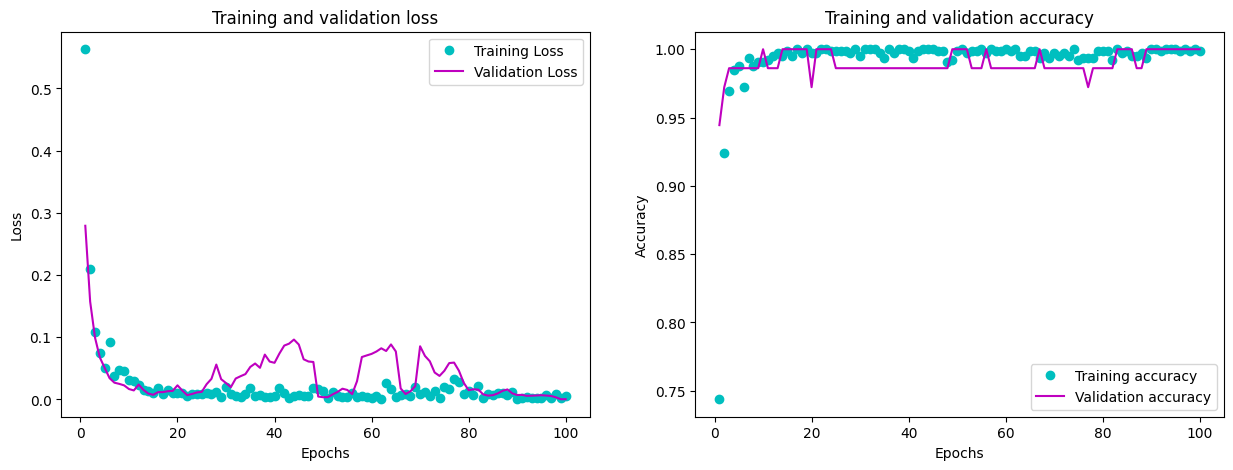

In [23]:
# plot training loss and accuracy

history_dict=history.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,101)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [24]:
model.evaluate(X_test, y_test)

6/6 [==============================] - 0s 2ms/step - loss: 0.1088 - accuracy: 0.9889


[0.10877933353185654, 0.9888888597488403]

In [25]:
preds = model.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

6/6 [==============================] - 0s 2ms/step
CONFUSION MATRIX ------------------
[[85  1]
 [ 1 93]]

TEST METRICS ----------------------
Accuracy: 98.88888888888889%
Precision: 98.93617021276596%
Recall: 98.93617021276596%
F1-score: 98.93617021276594%
Specificity: 98.83720930232558%


The simple dense neural network performed extremely well with an accuracy rate of 98.9%, only getting one false negative and oe false positive.  Lets see how our LSTM model performs with this dataset.

## RNN

In [61]:
model2 = tf.keras.Sequential([
    layers.LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    layers.Dropout(0.2),
    layers.LSTM(50),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
])

model2.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_8 (LSTM)               (None, 180, 50)           10400     
                                                                 
 dropout_17 (Dropout)        (None, 180, 50)           0         
                                                                 
 lstm_9 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_18 (Dropout)        (None, 50)                0         
                                                                 
 dense_16 (Dense)            (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [62]:
model2.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

es = EarlyStopping(monitor='val_loss', mode='min', patience=15, verbose=1)

history2 = model2.fit(X_train, y_train, epochs=100, validation_data=(X_val, y_val), callbacks=[es])

Epoch 1/100
21/21 [==============================] - 7s 166ms/step - loss: 0.6147 - accuracy: 0.6775 - val_loss: 0.4904 - val_accuracy: 0.7639
Epoch 2/100
21/21 [==============================] - 3s 122ms/step - loss: 0.5518 - accuracy: 0.7377 - val_loss: 0.4829 - val_accuracy: 0.7917
Epoch 3/100
21/21 [==============================] - 3s 125ms/step - loss: 0.5357 - accuracy: 0.7377 - val_loss: 0.4647 - val_accuracy: 0.8056
Epoch 4/100
21/21 [==============================] - 3s 125ms/step - loss: 0.5242 - accuracy: 0.7407 - val_loss: 0.4522 - val_accuracy: 0.7917
Epoch 5/100
21/21 [==============================] - 3s 123ms/step - loss: 0.5061 - accuracy: 0.7469 - val_loss: 0.4605 - val_accuracy: 0.7917
Epoch 6/100
21/21 [==============================] - 3s 123ms/step - loss: 0.5134 - accuracy: 0.7438 - val_loss: 0.4560 - val_accuracy: 0.7917
Epoch 7/100
21/21 [==============================] - 3s 124ms/step - loss: 0.5070 - accuracy: 0.7485 - val_loss: 0.4558 - val_accuracy: 0.7917

Epoch 58/100
21/21 [==============================] - 3s 126ms/step - loss: 0.1516 - accuracy: 0.9475 - val_loss: 0.2864 - val_accuracy: 0.8611
Epoch 59/100
21/21 [==============================] - 3s 125ms/step - loss: 0.1414 - accuracy: 0.9429 - val_loss: 0.2490 - val_accuracy: 0.9306
Epoch 60/100
21/21 [==============================] - 3s 126ms/step - loss: 0.0828 - accuracy: 0.9660 - val_loss: 0.1413 - val_accuracy: 0.9583
Epoch 61/100
21/21 [==============================] - 3s 136ms/step - loss: 0.0676 - accuracy: 0.9753 - val_loss: 0.1702 - val_accuracy: 0.9583
Epoch 62/100
21/21 [==============================] - 3s 135ms/step - loss: 0.0580 - accuracy: 0.9846 - val_loss: 0.0698 - val_accuracy: 0.9722
Epoch 63/100
21/21 [==============================] - 3s 127ms/step - loss: 0.0655 - accuracy: 0.9738 - val_loss: 0.1132 - val_accuracy: 0.9583
Epoch 64/100
21/21 [==============================] - 3s 127ms/step - loss: 0.0632 - accuracy: 0.9799 - val_loss: 0.2324 - val_accuracy:

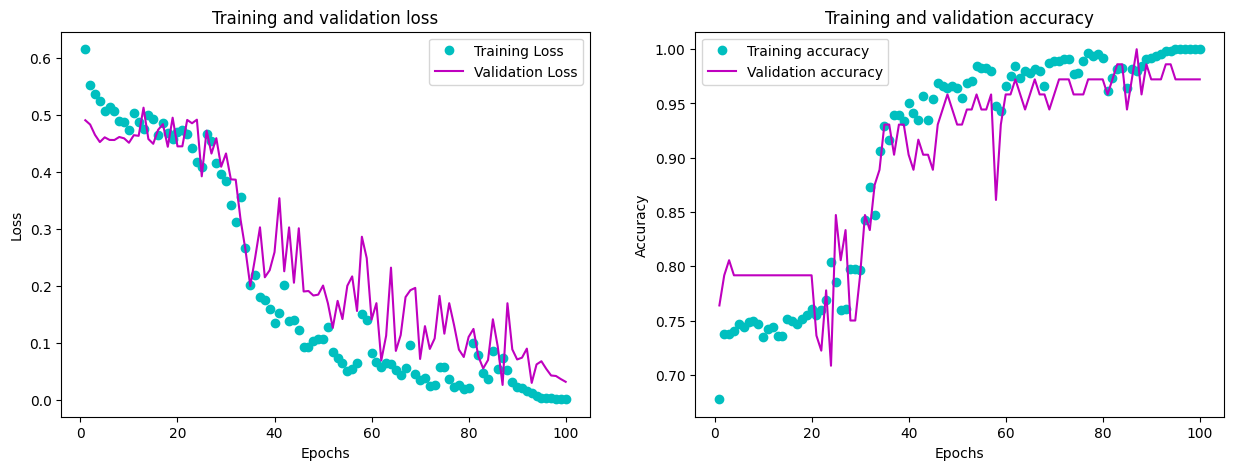

In [63]:
# plot training loss and accuracy

history_dict=history2.history
loss_values=history_dict['loss']
acc_values=history_dict['accuracy']
val_loss_values = history_dict['val_loss']
val_acc_values=history_dict['val_accuracy']
epochs=range(1,101)
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,5))
ax1.plot(epochs,loss_values,'co',label='Training Loss')
ax1.plot(epochs,val_loss_values,'m', label='Validation Loss')
ax1.set_title('Training and validation loss')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Loss')
ax1.legend()
ax2.plot(epochs,acc_values,'co', label='Training accuracy')
ax2.plot(epochs,val_acc_values,'m',label='Validation accuracy')
ax2.set_title('Training and validation accuracy')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Accuracy')
ax2.legend()
plt.show()

In [64]:
model2.evaluate(X_test, y_test)

6/6 [==============================] - 0s 39ms/step - loss: 0.0904 - accuracy: 0.9722


[0.09043798595666885, 0.9722222089767456]

In [65]:
preds = model2.predict(X_test)

acc = accuracy_score(y_test, np.round(preds))*100
cm = confusion_matrix(y_test, np.round(preds))
tn, fp, fn, tp = cm.ravel()

print('CONFUSION MATRIX ------------------')
print(cm)

print('\nTEST METRICS ----------------------')
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print(f'Accuracy: {acc}%')
print(f'Precision: {precision}%')
print(f'Recall: {recall}%')
print(f'F1-score: {2*precision*recall/(precision+recall)}%')
print(f'Specificity: {(tn/(tn + fp))*100}%')

6/6 [==============================] - 1s 37ms/step
CONFUSION MATRIX ------------------
[[90  4]
 [ 1 85]]

TEST METRICS ----------------------
Accuracy: 97.22222222222221%
Precision: 95.50561797752809%
Recall: 98.83720930232558%
F1-score: 97.14285714285714%
Specificity: 95.74468085106383%


The LSTM model also performs very well with an accuracy of 97.2%. The LSTM model also has only one false negative, but it has four false positives. The LSTM model took much longer to train than the simple dense model and took many more epochs to reach a high accuracy rate when compared to the simple dense model.

# Conclusion

I am able to distinguish between real and cloned voices with an extremely high accuracy rate using neural networks. I used a simple feed forward neural network which achieved a 98.9% accuracy rate and an LSTM model which achieved a 97.2% accuracy rate. 

I would use the simple feed forward neural network with the dataset that I used because it achieved a higher accuracy rate with a shorter training time than the LSTM model. However, since the voice datasets are unlikely to be exactly the same, I would recommend training a couple different models and finding the one that works best for your dataset.